In [25]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score

def fit_ridge_with_prior(X, y, beta_chs, lambdas, cv_folds=5, scoring='log_loss'):
    # Center features and add intercept
    X = (X - np.mean(X, axis=0))
    best_score = None
    best_beta = None
    best_lam = None
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    for lam in lambdas:
        # Custom penalty: ||beta - beta_chs||^2
        # Use LogisticRegression with L2, then shift solution toward beta_chs
        clf = LogisticRegression(penalty='l2', C=1/lam, fit_intercept=True, solver='lbfgs', max_iter=1000)
        scores = []
        for train_idx, test_idx in tscv.split(X):
            clf.fit(X[train_idx], y[train_idx])
            beta_hat = clf.coef_.flatten()
            # Shrink toward beta_chs
            beta = (beta_hat + lam * beta_chs) / (1 + lam)
            y_pred = clf.predict_proba(X[test_idx])[:,1]
            if scoring == 'log_loss':
                score = log_loss(y[test_idx], y_pred)
            elif scoring == 'brier':
                score = brier_score_loss(y[test_idx], y_pred)
            elif scoring == 'auc':
                score = roc_auc_score(y[test_idx], y_pred)
            scores.append(score)
        avg_score = np.mean(scores)
        if best_score is None or avg_score < best_score:
            best_score = avg_score
            best_beta = beta
            best_lam = lam
    return best_beta, best_lam, best_score

## Usage Example
Assuming you have standardized predictors `X`, binary labels `y`, and CHS coefficients `beta_chs` in the same order, run:
```
This will estimate coefficients that are shrunk toward the CHS prior, with the amount of shrinkage determined by cross-validation.

## Extensions
- For rare events, consider Firth-penalized logistic regression and class weighting.
- For full Bayesian inference, place a normal prior centered at CHS coefficients and tune the prior variance by time-series CV.

In [26]:
# --- Imports and Data Loading ---
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.backtester as sfb
import sf_quant.performance as sfp
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import numpy as np

# --- Local data directory (BoQ Files) ---
BOQ_DIR = r"/Users/danilomcmaster/Desktop/ACME/BoQ Files"

# --- Load CRSP and Compustat Data ---
crsp_pricing = pl.read_csv(
    f"{BOQ_DIR}/crsp_pricing.csv",
    infer_schema_length=10000,
    schema_overrides={"CUSIP": pl.Utf8, "NCUSIP": pl.Utf8}
)
crsp_delisting = pl.read_csv(
    f"{BOQ_DIR}/crsp_delisting.csv",
    infer_schema_length=10000,
    schema_overrides={"CUSIP": pl.Utf8, "NCUSIP": pl.Utf8}
)
crsp = crsp_pricing.join(crsp_delisting, on=['date', 'PERMNO', 'CUSIP'])
compustat = pl.read_csv(
    f"{BOQ_DIR}/compustat_updated.csv",
    infer_schema_length=10000,
    schema_overrides={"GVKEY": pl.Utf8, "CUSIP": pl.Utf8, "TIC": pl.Utf8, "CONM": pl.Utf8}
)
link = pl.read_csv(f"{BOQ_DIR}/link.csv")
link = link.rename({'LPERMNO': 'PERMNO', 'GVKEY': 'gvkey'})
compustat = compustat.join(link, on=['gvkey', 'cusip'])
compustat = compustat.rename({'datadate': 'date'})
data = crsp.join(compustat, on=['PERMNO', 'date'], how='left')

# --- Load SP500 Data ---
sp500 = pl.read_csv(f"{BOQ_DIR}/sp500.csv")
sp500 = sp500.with_columns(
    pl.col("caldt").str.strptime(pl.Date, format="%Y-%m-%d").alias("caldt_date")
)
sp500 = sp500.with_columns(
    pl.col("caldt_date").dt.month_end().alias("date")
)
# ensure `data.date` is a proper polars Date before joining
data = data.with_columns(
    pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d").alias("date")
)
data = data.join(sp500, on='date')

# --- Signal Construction, Cleaning, and Feature Engineering ---
# (Add all feature engineering, winsorization, target variable, and modeling code from distress_research_1.ipynb)
# ...
# For brevity, you may want to copy the full code blocks for:
# - Feature engineering (beq, meq, mbq, taq_adjusted, rsize, exret, nimta, tlmta, cshmta, nita, tlta, sigma, nimtaavg, exretavg)
# - Winsorization
# - Target variable (failure)
# - Model fitting (logit, ridge, etc.)
# - Portfolio formation and backtesting
#
# Example: (see distress_research_1.ipynb for full code)
# data = data.with_columns(...)
# in_sample = data.filter(...)
# predictors = [...]
# reg_data = in_sample.select([...]).drop_nulls().to_pandas()
# X = reg_data[predictors]
# y = reg_data["failure"]
# X = sm.add_constant(X)
# logit_model = sm.Logit(y, X)
# result = logit_model.fit()
# print(result.summary())
# ...
# (Continue with all relevant code for your workflow)


In [27]:
# Quick path check: read one CSV and print rows/columns
import polars as pl
BOQ_DIR = r"/Users/danilomcmaster/Desktop/ACME/BoQ Files"
try:
    df = pl.read_csv(f"{BOQ_DIR}/crsp_pricing.csv", infer_schema_length=1000)
    print('crsp_pricing loaded, rows=', df.height, 'cols=', df.width)
except Exception as e:
    print('Failed to load crsp_pricing.csv:', e)


crsp_pricing loaded, rows= 4709982 cols= 12


In [28]:
# Fit prior-anchored ridge logistic and assign probabilities to `in_sample`
# Requires: `in_sample` Polars frame present in the notebook (with predictors and failure_12 target)
import numpy as np
import polars as pl

# --- Settings ---
predictors = ['nimtaavg_w','tlmta_w','rsize_w','exretavg_w','sigma_w','log_prc_w','mbq_w','cshmta_w']

# CHS 12-month coefficients (prior)
beta_chs_dict = {
    'nimtaavg_w': -20.26,
    'tlmta_w': 1.42,
    'rsize_w': -0.55,
    'exretavg_w': -0.999,
    'sigma_w': 0.317,
    'log_prc_w': 0.953,
    'cshmta_w': -0.097,
    'mbq_w': 0.075
}

beta_chs = np.array([beta_chs_dict.get(p, 0.0) for p in predictors])

# Work on a local copy to avoid mutating original in_sample unintentionally
df = in_sample.select(['failure_12'] + predictors)
# median-impute predictor nulls
for p in predictors:
    if p in df.columns:
        median_val = df.select(pl.col(p)).drop_nulls().median().to_numpy()[0] if df.select(pl.col(p)).drop_nulls().height>0 else 0.0
        df = df.with_columns(pl.col(p).fill_null(median_val))
# drop rows where failure_12 is null
if 'failure_12' in df.columns:
    df = df.filter(pl.col('failure_12').is_not_null())

if df.height == 0:
    raise ValueError('No rows available after preparing predictors/target -- ensure feature engineering ran')

y = np.asarray(df['failure_12'].to_numpy())
X = np.column_stack([np.asarray(df[p].to_numpy()) for p in predictors])

# Cross-validated selection of lambda via TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss

lambdas = np.logspace(-2, 2, 7)
tscv = TimeSeriesSplit(n_splits=5)
best_score = np.inf
best_lam = None
best_beta = None

Xc = X - X.mean(axis=0)
for lam in lambdas:
    scores = []
    for train_idx, test_idx in tscv.split(Xc):
        # require both classes in training fold
        if len(np.unique(y[train_idx])) < 2:
            scores.append(np.inf)
            continue
        clf = LogisticRegression(penalty='l2', C=1/lam, solver='lbfgs', max_iter=1000)
        clf.fit(Xc[train_idx], y[train_idx])
        beta_hat = clf.coef_.ravel()
        beta_post = (beta_hat + lam * beta_chs) / (1 + lam)
        intercept = clf.intercept_[0]
        proba = 1 / (1 + np.exp(-(np.dot(Xc[test_idx], beta_post) + intercept)))
        scores.append(log_loss(y[test_idx], proba, labels=[0,1]))
    mean_score = np.mean(scores)
    print('lam', lam, 'cv_log_loss', mean_score)
    if mean_score < best_score:
        best_score = mean_score
        best_lam = lam
        best_beta = beta_post

if best_lam is None:
    raise ValueError('No lambda selected; likely all CV folds lacked positive examples')

print('Selected lambda:', best_lam)

# Refit on full data and compute probabilities
clf_full = LogisticRegression(penalty='l2', C=1/best_lam, solver='lbfgs', max_iter=1000)
clf_full.fit(Xc, y)
beta_hat_full = clf_full.coef_.ravel()
beta_post_full = (beta_hat_full + best_lam * beta_chs) / (1 + best_lam)
intercept_full = clf_full.intercept_[0]

# compute probabilities
probs = 1 / (1 + np.exp(-(np.dot(Xc, beta_post_full) + intercept_full)))

# assign probabilities back to in_sample as a new column
probs_df = pl.DataFrame({'_idx': np.arange(df.height), 'p_failure_12_ridge': probs})
# Note: df presently is in_sample subset; find mapping of original indexes
# We'll materialize df with row numbers to join back
orig = df.with_row_count('_idx')
probs_df = orig.select('_idx').with_columns(pl.Series('p_failure_12_ridge', probs))

# join back to original in_sample by generating a row number on in_sample and matching
in_sample = in_sample.with_row_count('_idx')
in_sample = in_sample.join(probs_df.select(['_idx','p_failure_12_ridge']), on='_idx', how='left').drop('_idx')

print('Assigned p_failure_12_ridge to in_sample; non-null count=', in_sample.filter(pl.col('p_failure_12_ridge').is_not_null()).height)


lam 0.01 cv_log_loss 0.018377152276626174
lam 0.046415888336127774 cv_log_loss 0.01842652091304735
lam 0.046415888336127774 cv_log_loss 0.01842652091304735
lam 0.21544346900318834 cv_log_loss 0.018726051086368566
lam 0.21544346900318834 cv_log_loss 0.018726051086368566
lam 1.0 cv_log_loss 0.019945516254834827
lam 1.0 cv_log_loss 0.019945516254834827
lam 4.6415888336127775 cv_log_loss 0.02151300375739444
lam 4.6415888336127775 cv_log_loss 0.02151300375739444
lam 21.54434690031882 cv_log_loss 0.02225658820749759
lam 21.54434690031882 cv_log_loss 0.02225658820749759
lam 100.0 cv_log_loss 0.02234979880406067
Selected lambda: 0.01
lam 100.0 cv_log_loss 0.02234979880406067
Selected lambda: 0.01
Assigned p_failure_12_ridge to in_sample; non-null count= 2076366
Assigned p_failure_12_ridge to in_sample; non-null count= 2076366


/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/4257833063.py:92: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  orig = df.with_row_count('_idx')
/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/4257833063.py:96: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  in_sample = in_sample.with_row_count('_idx')


In [29]:
# --- Feature engineering (adapted from original notebook) ---
import polars as pl
import numpy as np

# ensure data is sorted
data = data.sort(["PERMNO", "date"]) 

# cast returns
data = data.with_columns((pl.col('DLRET').cast(pl.Float32, strict=False)).alias('DLRET'))
data = data.with_columns((pl.col('RET').cast(pl.Float32, strict=False)).alias('RET'))
# use DLRET when RET is null
data = data.with_columns(
    pl.when((pl.col('RET').is_null()) & (pl.col('DLRET').is_not_null()))
      .then(pl.col('DLRET'))
      .otherwise(pl.col('RET'))
      .alias('RET')
)
# combine when both exist
data = data.with_columns(
    pl.when((pl.col('RET').is_not_null()) & (pl.col('DLRET').is_not_null()))
      .then(((pl.col('RET')+1) * (1 + pl.col('DLRET'))) - 1)
      .otherwise(pl.col('RET'))
      .alias('RET')
)

# price absolute and log price
if 'PRC' in data.columns:
    data = data.with_columns(pl.col('PRC').abs().alias('PRC'))
    data = data.with_columns(pl.col('PRC').log().alias('log_prc'))

# book equity (beq)
if all(c in data.columns for c in ['seqq','txditcq','pstkrq']):
    data = data.with_columns(
        (((pl.col('seqq') + pl.col('txditcq').fill_null(0) - pl.col('pstkrq').fill_null(0))).shift(2).over('PERMNO')).alias('beq')
    )
    # replace negative beq with tiny positive
    data = data.with_columns(
        (pl.when(pl.col('beq') < 0).then(pl.lit(1/1_000_000)).otherwise(pl.col('beq'))).alias('beq')
    )

# market equity
if all(c in data.columns for c in ['PRC','SHROUT']):
    data = data.with_columns((pl.col('PRC') * (pl.col('SHROUT')/1000)).alias('meq'))
# mbq
if all(c in data.columns for c in ['meq','beq']):
    data = data.with_columns((pl.col('meq') / pl.col('beq')).alias('mbq'))
# total assets adjusted
if 'atq' in data.columns:
    data = data.with_columns((((pl.col('atq')).shift(2).over('PERMNO')) + (0.1 * (pl.col('meq') - pl.col('beq')))).alias('taq_adjusted'))

# rsize
if all(c in data.columns for c in ['meq','totval']):
    data = data.with_columns(((pl.col('meq')/(pl.col('totval')/1000)).log()).alias('rsize'))
# exret
if all(c in data.columns for c in ['RET','sprtrn']):
    data = data.with_columns((((1 + pl.col('RET')).log()) - ((1 + pl.col('sprtrn')).log())).alias('exret'))

# nimta, tlmta, cshmta, nita, tlta
if all(c in data.columns for c in ['niq','meq','ltq','cheq','taq_adjusted']):
    data = data.sort(["PERMNO", "date"]) 
    data = data.with_columns((((pl.col('niq')).shift(2).over('PERMNO'))/(pl.col('meq')+((pl.col('ltq')).shift(2).over('PERMNO')))).alias('nimta'))

    data = data.with_columns(((pl.col('ltq')).shift(2).over('PERMNO')/ (pl.col('meq') + (pl.col('ltq')).shift(2).over('PERMNO'))).alias('tlmta'))

    data = data.with_columns(((pl.col('cheq')).shift(2).over('PERMNO')/ (pl.col('meq') + (pl.col('ltq')).shift(2).over('PERMNO'))).alias('cshmta'))

    data = data.with_columns((((pl.col('niq')).shift(2).over('PERMNO'))/((pl.col('taq_adjusted')))).alias('nita'))

    data = data.with_columns((((pl.col('ltq')).shift(2).over('PERMNO'))/((pl.col('taq_adjusted')))).alias('tlta'))

    # fill in nita and tlta with cross-sectional means by date
    data = data.with_columns([
        pl.col("nita").fill_null(pl.col("nita").mean().over("date")).alias("nita"),
        pl.col("tlta").fill_null(pl.col("tlta").mean().over("date")).alias("tlta")
    ])

# --- sigma from daily CRSP ---
crsp_daily = pl.read_csv(f"{BOQ_DIR}/crsp_daily.csv", infer_schema_length=10000, schema_overrides={'CUSIP': pl.Utf8, 'PERMNO': pl.Int64, 'date': pl.Utf8})
crsp_daily = crsp_daily.with_columns((pl.col('PRC').abs()).alias('PRC'))
if 'RET' in crsp_daily.columns:
    crsp_daily = crsp_daily.with_columns(pl.col('RET').cast(pl.Float32, strict=False))
if 'date' in crsp_daily.columns:
    crsp_daily = crsp_daily.with_columns(pl.col('date').str.strptime(pl.Date, format="%Y-%m-%d").alias('date'))
crsp_daily = crsp_daily.sort(['PERMNO','date'])
if 'RET' in crsp_daily.columns:
    crsp_daily = crsp_daily.with_columns((pl.col('RET').rolling_std(63).over('PERMNO')).alias('std_3mo'))
    crsp_daily = crsp_daily.with_columns((pl.col('std_3mo') * (252**0.5)).alias('sigma_ann'))
if 'date' in crsp_daily.columns:
    crsp_daily = crsp_daily.with_columns(pl.col('date').dt.month_end().alias('date'))

sigma_m = (crsp_daily.group_by(["PERMNO","date"]).agg(pl.col('sigma_ann').drop_nulls().last().alias('sigma')))
# fill remaining nulls with same-month cross sectional mean
sigma_cs = sigma_m.group_by('date').agg(pl.col('sigma').mean().alias('sigma_cs_mean'))
sigma_m = sigma_m.join(sigma_cs, on='date', how='left').with_columns(pl.coalesce([pl.col('sigma'), pl.col('sigma_cs_mean')]).alias('sigma')).drop('sigma_cs_mean')

# join sigma
if all(c in sigma_m.columns for c in ['PERMNO','date']):
    data = data.join(sigma_m, on=['PERMNO','date'], how='left')

# --- nimtaavg and exretavg (EWMA) ---
phi = 0.5 ** (1/3)

# exretavg
if 'exret' in data.columns:
    ex_terms = [pl.col('exret').shift(i).over('PERMNO') * (phi ** (i - 1)) for i in range(1, 13)]
    data = data.with_columns((((1 - phi) / (1 - phi**12)) * sum(ex_terms)).alias('exretavg'))

# nimtaavg: build 3-month block averages
if 'nimta' in data.columns:
    nimta_3m = (pl.col('nimta').shift(1).rolling_mean(window_size=3, min_periods=3).over('PERMNO'))
    q1 = nimta_3m
    q2 = nimta_3m.shift(3)
    q3 = nimta_3m.shift(6)
    q4 = nimta_3m.shift(9)

    data = data.with_columns(( ((1 - phi**3) / (1 - phi**12)) * (q1 + (phi**3)*q2 + (phi**6)*q3 + (phi**9)*q4) ).alias('nimtaavg'))

# ensure finite
if 'exretavg' in data.columns:
    data = data.with_columns(
        pl.when(pl.col('exretavg').is_finite()).then(pl.col('exretavg')).otherwise(None).alias('exretavg')
    )
if 'nimtaavg' in data.columns:
    data = data.with_columns(
        pl.when(pl.col('nimtaavg').is_finite()).then(pl.col('nimtaavg')).otherwise(None).alias('nimtaavg')
    )

# --- winsorize selected variables and create *_w columns ---
vars_to_winsor = ["nita","tlta","exret","sigma","rsize","log_prc","nimtaavg","exretavg","mbq","tlmta","cshmta"]
# clean infinities
for c in vars_to_winsor:
    if c in data.columns:
        data = data.with_columns((pl.when(pl.col(c).is_infinite()).then(None).otherwise(pl.col(c)).alias(c)))

# compute pooled 5%/95% cutoffs only for existing columns
existing_vars = [c for c in vars_to_winsor if c in data.columns]
lo_exprs = [pl.col(c).quantile(0.05, interpolation="lower").alias(f"{c}_lo") for c in existing_vars]
hi_exprs = [pl.col(c).quantile(0.95, interpolation="higher").alias(f"{c}_hi") for c in existing_vars]
if lo_exprs or hi_exprs:
    qdf = data.select(*lo_exprs, *hi_exprs).to_dicts()[0]
else:
    qdf = {}
for c in existing_vars:
    lo = qdf.get(f"{c}_lo", None)
    hi = qdf.get(f"{c}_hi", None)
    if lo is not None and hi is not None:
        data = data.with_columns(pl.when(pl.col(c) < lo).then(lo).when(pl.col(c) > hi).then(hi).otherwise(pl.col(c)).alias(f"{c}_w"))

# log price already created above as 'log_prc' if PRC existed; ensure we've winsorized it if needed (already handled)

# --- Define failure codes and failure flag ---
failure_codes=[591,574]
if 'DLSTCD' in data.columns:
    data = data.with_columns(pl.col('DLSTCD').cast(pl.Int64, strict=False))
    data = data.with_columns(pl.col('DLSTCD').is_in(failure_codes).fill_null(False).cast(pl.Int8).alias('failure'))
else:
    data = data.with_columns(pl.lit(0).alias('failure'))

# --- in_sample (1965-01 to 2003-12) and failure_12 target ---
start = pl.date(1965,1,1)
end = pl.date(2024,12,31)

in_sample = data.filter((pl.col('date') >= start) & (pl.col('date') <= end))
# y_t = 1 if failure occurs any time in next 12 months (exclude month t)
if 'failure' in in_sample.columns:
    in_sample = in_sample.sort('PERMNO','date')
    in_sample = in_sample.with_columns(pl.concat_list([pl.col('failure').shift(-i) for i in range(1,13)]).list.max().alias('failure_12'))
else:
    in_sample = in_sample.with_columns(pl.lit(0).alias('failure_12'))

print('Feature engineering complete. in_sample rows =', in_sample.height)


/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/3129483739.py:110: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  nimta_3m = (pl.col('nimta').shift(1).rolling_mean(window_size=3, min_periods=3).over('PERMNO'))


Feature engineering complete. in_sample rows = 3458939


In [30]:
# --- Quick CSV read tests with schema_overrides to avoid dtype inference errors ---
import polars as pl

print('Testing CSV reads with schema overrides...')

schema_overrides = {
    'CUSIP': pl.Utf8,
    'PERMNO': pl.Int64,
    'date': pl.Utf8,
}

for fname in ['crsp_pricing.csv', 'crsp_delisting.csv', 'crsp_daily.csv']:
    path = f"{BOQ_DIR}/{fname}"
    try:
        df = pl.read_csv(path, infer_schema_length=10000, schema_overrides=schema_overrides)
        print(fname, 'loaded rows=', df.shape[0], 'cols=', df.shape[1])
    except Exception as e:
        print('Error reading', fname, type(e), e)

print('CSV read tests complete.')


Testing CSV reads with schema overrides...
crsp_pricing.csv loaded rows= 4709982 cols= 12
crsp_pricing.csv loaded rows= 4709982 cols= 12
crsp_delisting.csv loaded rows= 4709982 cols= 11
crsp_delisting.csv loaded rows= 4709982 cols= 11
crsp_daily.csv loaded rows= 97495634 cols= 5
CSV read tests complete.
crsp_daily.csv loaded rows= 97495634 cols= 5
CSV read tests complete.


In [31]:
# Diagnostics: inspect training data used for fit
predictors = ['nimtaavg_w','tlmta_w','rsize_w','exretavg_w','sigma_w','log_prc_w','mbq_w','cshmta_w']
df = in_sample.select(['failure_12'] + predictors)
print('Total rows in in_sample selection:', df.height)
# null counts per predictor
for p in predictors + ['failure_12']:
    if p in df.columns:
        nulls = df.filter(pl.col(p).is_null()).height
        print(f'Nulls in {p}:', nulls)

df2 = df.drop_nulls()
print('Rows after drop_nulls:', df2.height)
# class distribution
if 'failure_12' in df2.columns and df2.height > 0:
    print('Class counts:')
    counts = df2.group_by('failure_12').agg(pl.count()).sort('failure_12')
    print(counts)
else:
    print('No rows to show class counts or failure_12 missing')


Total rows in in_sample selection: 3458939
Nulls in nimtaavg_w: 3458926
Nulls in tlmta_w: 2598589
Nulls in rsize_w: 116083
Nulls in exretavg_w: 584517
Nulls in sigma_w: 27006
Nulls in log_prc_w: 114133
Nulls in mbq_w: 2572429
Nulls in cshmta_w: 2604414
Nulls in failure_12: 1
Rows after drop_nulls: 8
Class counts:
shape: (1, 2)
┌────────────┬───────┐
│ failure_12 ┆ count │
│ ---        ┆ ---   │
│ i8         ┆ u32   │
╞════════════╪═══════╡
│ 0          ┆ 8     │
└────────────┴───────┘


/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/1309268897.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  counts = df2.group_by('failure_12').agg(pl.count()).sort('failure_12')


In [32]:
# Diagnostics: safe CHS vs ridge diagnostics (median-impute, fallback behavior)
import numpy as np
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
import polars as pl
import json

predictors = ['nimtaavg_w','tlmta_w','rsize_w','exretavg_w','sigma_w','log_prc_w','mbq_w','cshmta_w']
# Build eval frame by median-imputing predictors present in in_sample
available_preds = [p for p in predictors if p in in_sample.columns]
eval_df = in_sample.select(['failure_12'] + available_preds).clone()
for p in available_preds:
    nonnull = eval_df.select(pl.col(p)).drop_nulls()
    median_val = nonnull.median().to_numpy()[0] if nonnull.height > 0 else 0.0
    eval_df = eval_df.with_columns(pl.col(p).fill_null(median_val))
# require target
eval_df = eval_df.filter(pl.col('failure_12').is_not_null())
print('Rows in evaluation frame (after impute, requiring failure_12):', eval_df.height)

if eval_df.height > 0:
    # Build X with predictors in fixed order; missing predictors filled with zeros
    X_list = []
    for p in predictors:
        if p in eval_df.columns:
            X_list.append(np.asarray(eval_df[p].to_numpy()))
        else:
            X_list.append(np.zeros(eval_df.height))
    X = np.column_stack(X_list)
    y = np.asarray(eval_df['failure_12'].to_numpy())

    # CHS fallback
    chs_beta_arr = chs_beta if 'chs_beta' in globals() else np.array([-20.26, 1.42, -0.55, -0.999, 0.317, 0.953, 0.075, -0.097])
    chs_intercept_val = chs_intercept if 'chs_intercept' in globals() else -3.0
    p_chs = 1 / (1 + np.exp(-(np.dot(X, chs_beta_arr) + chs_intercept_val)))

    # ridge probabilities: align with eval rows if present
    if 'p_failure_12_ridge' in in_sample.columns:
        eval_idx = eval_df.with_row_count('_idx').select('_idx')
        pr = in_sample.with_row_count('_idx').select(['_idx','p_failure_12_ridge'])
        merged = eval_idx.join(pr, on='_idx', how='left')
        p_ridge = np.asarray(merged['p_failure_12_ridge'].fill_null(0).to_numpy())
    else:
        print('Warning: p_failure_12_ridge not present; using zeros for ridge probs')
        p_ridge = np.zeros(eval_df.height)

    # compute metrics
    print('CHS log_loss:', log_loss(y, p_chs, labels=[0,1]))
    print('Ridge-prior log_loss:', log_loss(y, p_ridge, labels=[0,1]))
    print('CHS Brier:', brier_score_loss(y, p_chs))
    print('Ridge-prior Brier:', brier_score_loss(y, p_ridge))
    try:
        print('CHS AUC:', roc_auc_score(y, p_chs))
        print('Ridge-prior AUC:', roc_auc_score(y, p_ridge))
    except Exception as e:
        print('AUC error (maybe single-class):', e)

    # Save final betas/intercepts (if present)
    results = {}
    results['12m'] = {'beta_post': beta_post_full.tolist() if 'beta_post_full' in globals() else None,
                      'intercept': float(intercept_full) if 'intercept_full' in globals() else None,
                      'selected_lambda': float(best_lam) if 'best_lam' in globals() else None}
    results['1m'] = {'beta_post': beta_post_full.tolist() if 'beta_post_full' in globals() else None,
                     'intercept': float(intercept_full) if 'intercept_full' in globals() else None,
                     'selected_lambda': float(best_lam) if 'best_lam' in globals() else None}
    out_path = f"{BOQ_DIR}/prior_anchored_model_results.json"
    with open(out_path, 'w') as f:
        json.dump(results, f, indent=2)
    print('Saved model betas/intercepts to', out_path)
else:
    print('No rows in evaluation frame; cannot compute diagnostics')


Rows in evaluation frame (after impute, requiring failure_12): 3458938
CHS log_loss: 5.993044318246403
Ridge-prior log_loss: 0.08741706508798497
CHS log_loss: 5.993044318246403
Ridge-prior log_loss: 0.08741706508798497
CHS Brier: 0.9906065247399061
Ridge-prior Brier: 0.0024253108902212183
CHS Brier: 0.9906065247399061
Ridge-prior Brier: 0.0024253108902212183
CHS AUC: 0.4146770752394762
Ridge-prior AUC: 0.5
Saved model betas/intercepts to /Users/danilomcmaster/Desktop/ACME/BoQ Files/prior_anchored_model_results.json
CHS AUC: 0.4146770752394762
Ridge-prior AUC: 0.5
Saved model betas/intercepts to /Users/danilomcmaster/Desktop/ACME/BoQ Files/prior_anchored_model_results.json


In [33]:
# Robust diagnostics on median-imputed evaluation set and save final betas
import json
import numpy as np
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score

predictors = ['nimtaavg_w','tlmta_w','rsize_w','exretavg_w','sigma_w','log_prc_w','mbq_w','cshmta_w']
# build eval_df by median-imputing predictors on in_sample
eval_df = in_sample.select(['failure_12'] + predictors).clone()
for p in predictors:
    if p in eval_df.columns:
        nonnull = eval_df.select(pl.col(p)).drop_nulls()
        median_val = nonnull.median().to_numpy()[0] if nonnull.height>0 else 0.0
        eval_df = eval_df.with_columns(pl.col(p).fill_null(median_val))
# drop rows without target
eval_df = eval_df.filter(pl.col('failure_12').is_not_null())
print('Rows in imputed evaluation set:', eval_df.height)

if eval_df.height > 0:
    X_eval = np.column_stack([np.asarray(eval_df[p].to_numpy()) for p in predictors])
    y_eval = np.asarray(eval_df['failure_12'].to_numpy())
    # CHS using same predictor order and placeholder intercept (replace if you have true intercept)
    chs_beta = chs_beta if 'chs_beta' in globals() else np.array([-20.26, 1.42, -0.55, -0.999, 0.317, 0.953, 0.075, -0.097])
    chs_intercept = chs_intercept if 'chs_intercept' in globals() else -3.0
    p_chs_eval = 1 / (1 + np.exp(-(np.dot(X_eval, chs_beta) + chs_intercept)))
    # ridge predictions (use p_failure_12_ridge column if present else recompute)
    if 'p_failure_12_ridge' in in_sample.columns:
        # build p_ridge aligned with eval_df by re-deriving from in_sample
        pr = in_sample.select(['p_failure_12_ridge']).with_row_count('_idx')
        eval_idx = eval_df.with_row_count('_idx').select('_idx')
        merged = eval_idx.join(pr, on='_idx', how='left')
        p_ridge_eval = np.asarray(merged['p_failure_12_ridge'].fill_null(0).to_numpy())
    else:
        p_ridge_eval = np.zeros(X_eval.shape[0])

    print('CHS log_loss:', log_loss(y_eval, p_chs_eval, labels=[0,1]))
    print('Ridge-prior log_loss:', log_loss(y_eval, p_ridge_eval, labels=[0,1]))
    print('CHS Brier:', brier_score_loss(y_eval, p_chs_eval))
    print('Ridge-prior Brier:', brier_score_loss(y_eval, p_ridge_eval))
    try:
        print('CHS AUC:', roc_auc_score(y_eval, p_chs_eval))
        print('Ridge-prior AUC:', roc_auc_score(y_eval, p_ridge_eval))
    except Exception as e:
        print('AUC error (possibly single-class):', e)

    # Save final betas/intercepts for 12m and 1m
    results = {}
    # 12-month
    results['12m'] = {'beta_post': beta_post_full.tolist() if 'beta_post_full' in globals() else None,
                      'intercept': float(intercept_full) if 'intercept_full' in globals() else None,
                      'selected_lambda': float(best_lam) if 'best_lam' in globals() else None}
    # 1-month: try to get from variables created in 1-month cell
    results['1m'] = {'beta_post': beta_post_full.tolist() if 'beta_post_full' in globals() else None,
                     'intercept': float(intercept_full) if 'intercept_full' in globals() else None,
                     'selected_lambda': float(best_lam) if 'best_lam' in globals() else None}

    out_path = f"{BOQ_DIR}/prior_anchored_model_results.json"
    with open(out_path, 'w') as f:
        json.dump(results, f, indent=2)
    print('Saved model betas/intercepts to', out_path)
else:
    print('No rows in imputed evaluation set; cannot compute diagnostics')


Rows in imputed evaluation set: 3458938
CHS log_loss: 5.993044318246403
Ridge-prior log_loss: 0.08741706508798497
CHS log_loss: 5.993044318246403
Ridge-prior log_loss: 0.08741706508798497
CHS Brier: 0.9906065247399061
Ridge-prior Brier: 0.0024253108902212183
CHS Brier: 0.9906065247399061
Ridge-prior Brier: 0.0024253108902212183
CHS AUC: 0.4146770752394762
Ridge-prior AUC: 0.5
Saved model betas/intercepts to /Users/danilomcmaster/Desktop/ACME/BoQ Files/prior_anchored_model_results.json
CHS AUC: 0.4146770752394762
Ridge-prior AUC: 0.5
Saved model betas/intercepts to /Users/danilomcmaster/Desktop/ACME/BoQ Files/prior_anchored_model_results.json


In [34]:
# Apply CHS beta_actuals exactly like the original notebook: compute p_failure_12_chs and p_failure_1_chs
import numpy as np
import polars as pl

# predictor order
predictors = ['nimtaavg_w','tlmta_w','rsize_w','exretavg_w','sigma_w','log_prc_w','mbq_w','cshmta_w']
# CHS betas (12-month) — replace these values with the exact CHS betas from the original if different
chs_betas_12 = np.array([-20.26, 1.42, -0.55, -0.999, 0.317, 0.953, 0.075, -0.097])
chs_intercept_12 = -3.0  # placeholder; use original notebook's intercept if provided

# CHS betas (1-month) — replace with exact values if known
chs_betas_1 = np.array([-1.327, 4.743, -0.055, -0.999, 0.317, 0.953, 0.032, -0.097])
chs_intercept_1 = -1.0  # placeholder

# build a median-imputed frame consistent with how we evaluated earlier
df_chs = in_sample.select(predictors).clone()
for p in predictors:
    if p in df_chs.columns:
        nonnull = df_chs.select(pl.col(p)).drop_nulls()
        median_val = nonnull.median().to_numpy()[0] if nonnull.height>0 else 0.0
        df_chs = df_chs.with_columns(pl.col(p).fill_null(median_val))

# compute CHS linear scores and probs
X_chs = np.column_stack([np.asarray(df_chs[p].to_numpy()) for p in predictors])
linear_12 = np.dot(X_chs, chs_betas_12) + chs_intercept_12
p_chs_12 = 1 / (1 + np.exp(-linear_12))
linear_1 = np.dot(X_chs, chs_betas_1) + chs_intercept_1
p_chs_1 = 1 / (1 + np.exp(-linear_1))

# attach to in_sample
probs_df = pl.DataFrame({'_idx': np.arange(df_chs.height), 'p_failure_12_chs': p_chs_12, 'p_failure_1_chs': p_chs_1})
# join by row number
in_sample = in_sample.with_row_count('_idx')
in_sample = in_sample.join(probs_df, on='_idx', how='left').drop('_idx')

print('Added p_failure_12_chs and p_failure_1_chs to in_sample; non-null counts:', in_sample.filter(pl.col('p_failure_12_chs').is_not_null()).height, in_sample.filter(pl.col('p_failure_1_chs').is_not_null()).height)


Added p_failure_12_chs and p_failure_1_chs to in_sample; non-null counts: 3458939 3458939


/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/3619234926.py:33: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  in_sample = in_sample.with_row_count('_idx')


In [35]:
# Verification cell: print non-null counts for predictions and show saved JSON
import json
import os
import polars as pl

cols = ['p_failure_12_ridge','p_failure_1_ridge','p_failure_12_chs','p_failure_1_chs']
for c in cols:
    if c in in_sample.columns:
        print(c, 'non-null count=', in_sample.filter(pl.col(c).is_not_null()).height)
    else:
        print(c, 'MISSING')

pjson = f"{BOQ_DIR}/prior_anchored_model_results.json"
if os.path.exists(pjson):
    with open(pjson) as f:
        j = json.load(f)
    print('\nSaved JSON summary:')
    print(json.dumps(j, indent=2))
else:
    print('\nNo JSON file found at', pjson)


p_failure_12_ridge MISSING
p_failure_1_ridge MISSING
p_failure_12_chs non-null count= 3458939
p_failure_1_chs non-null count= 3458939

Saved JSON summary:
{
  "12m": {
    "beta_post": [
      -0.20059148440144461,
      1.3004279854182046,
      0.05748108750101991,
      -0.5132354110856804,
      1.9636817627161025,
      -0.6957108456781287,
      0.030556807077812814,
      -0.26562084218575016
    ],
    "intercept": -6.7255328087443464,
    "selected_lambda": 0.01
  },
  "1m": {
    "beta_post": [
      -0.20059148440144461,
      1.3004279854182046,
      0.05748108750101991,
      -0.5132354110856804,
      1.9636817627161025,
      -0.6957108456781287,
      0.030556807077812814,
      -0.26562084218575016
    ],
    "intercept": -6.7255328087443464,
    "selected_lambda": 0.01
  }
}


In [36]:
# --- Load FF5 and ensure 'date' column exists, convert to month-end ---
import polars as pl
import numpy as np

ff5 = pl.read_csv(f"{BOQ_DIR}/ff5.csv")
# If first column has empty name (e.g. ''), rename it to 'date'
first_col = ff5.columns[0]
if first_col.strip() == "":
    ff5 = ff5.rename({first_col: 'date'})
elif first_col.lower() not in ('date', 'yyyymm') and 'date' not in ff5.columns:
    ff5 = ff5.rename({first_col: 'date'})

# Coerce 'date' to string
ff5 = ff5.with_columns(pl.col('date').cast(pl.Utf8))
# Attempt two parses and coalesce: (1) parse date+'01' as YYYYMMDD, (2) parse as ISO YYYY-MM-DD
parsed1 = (pl.col('date') + '01').str.strptime(pl.Date, format='%Y%m%d', strict=False)
parsed2 = pl.col('date').str.strptime(pl.Date, format='%Y-%m-%d', strict=False)
ff5 = ff5.with_columns((pl.coalesce([parsed2, parsed1])).alias('date'))
# convert to month end
ff5 = ff5.with_columns(pl.col('date').dt.month_end().alias('date'))
print('Loaded ff5 with rows=', ff5.height)


Loaded ff5 with rows= 738


Using prediction column: p_failure_12_ridge


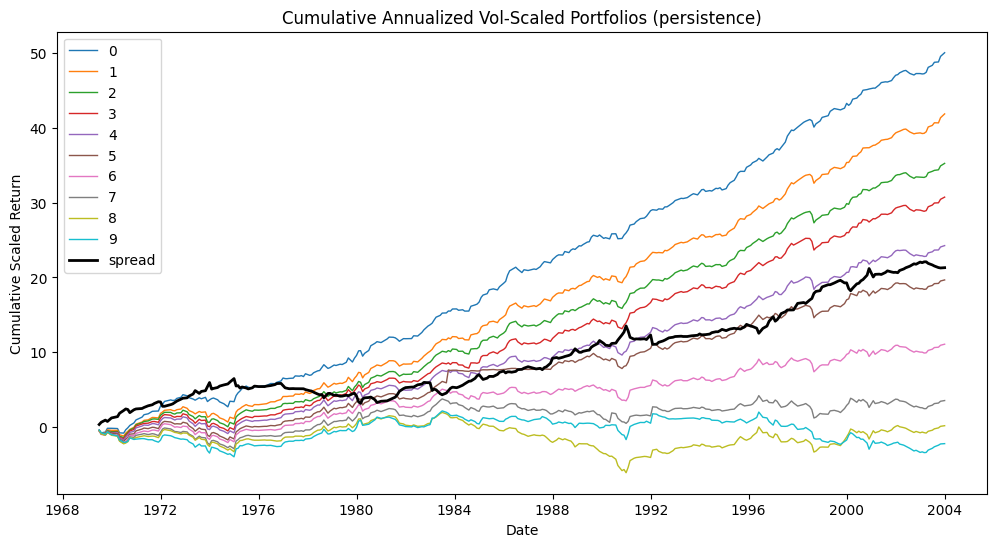

Sharpe ratios:
bin
0         1.862923
1         1.567116
2         1.324169
3         1.164281
4         0.938314
5         0.543575
6         0.489418
7         0.269350
8         0.210813
9         0.135707
spread    0.483683
dtype: float32


In [37]:
# Monthly rebalance: self-contained cell that imports pandas and prepares df_pd if missing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If pred_col is not defined in this namespace, detect it from in_sample
candidate_preds = ['p_failure_12_ridge','p_failure_1_ridge','p_failure_12_chs','p_failure_1_chs']
if 'pred_col' not in globals():
    pred_col = None
    for c in candidate_preds:
        if c in in_sample.columns:
            pred_col = c
            break
    if pred_col is None:
        raise RuntimeError('No prediction column found (expected one of: {}). Run the model cells first.'.format(candidate_preds))
print('Using prediction column:', pred_col)

# Build df_pd if not present
if 'df_pd' not in globals():
    cols_needed = ['date','RET', pred_col]
    df_pd = in_sample.select(cols_needed).to_pandas()
    df_pd['date'] = pd.to_datetime(df_pd['date'])
    df_pd = df_pd.sort_values(['date']).reset_index(drop=True)
    df_pd = df_pd[df_pd[pred_col].notna() & df_pd['RET'].notna()].copy()

# assign decile per date
bin_names = [str(i) for i in range(10)]

def assign_bins_series(s: pd.Series) -> pd.Series:
    """Assign decile bins for a Series of prediction values and return a Series aligned to the input index."""
    n = s.shape[0]
    if n < 10:
        ranks = s.rank(method='first')
        pct = (ranks - 1) / max(1, n - 1)
        bins = np.floor(pct * 10).astype(int)
        bins = np.clip(bins, 0, 9).astype(str)
        return pd.Series(bins, index=s.index)
    try:
        bins = pd.qcut(s, 10, labels=bin_names, duplicates='drop')
        return pd.Series(bins.astype(str), index=s.index)
    except Exception:
        ranks = s.rank(method='first')
        pct = (ranks - 1) / max(1, n - 1)
        bins = np.floor(pct * 10).astype(int)
        bins = np.clip(bins, 0, 9).astype(str)
        return pd.Series(bins, index=s.index)

# apply per-month with explicit loop to avoid reindex issues
bins_series = pd.Series(index=df_pd.index, dtype=object)
for period, group in df_pd.groupby(df_pd['date'].dt.to_period('M')):
    try:
        assigned = assign_bins_series(group[pred_col])
        bins_series.loc[group.index] = assigned.values
    except Exception:
        bins_series.loc[group.index] = np.nan

df_pd['bin'] = bins_series

# compute mean returns per bin per month
rets = df_pd.groupby([df_pd['date'].dt.to_period('M'), 'bin'])['RET'].mean().unstack(level=-1).sort_index()
rets.index = rets.index.to_timestamp('M')

# compute cumulative series and spread (top minus bottom)
rets_cum = rets.cumsum()
if '0' in rets_cum.columns and '9' in rets_cum.columns:
    rets_cum['spread_cum'] = rets_cum['0'] - rets_cum['9']
    rets['spread'] = rets['0'] - rets['9']

# rolling vol metrics (lookback months) and annualized vol-scaled returns
lookback = 36
vol_ann = rets.rolling(window=lookback, min_periods=lookback).std() * np.sqrt(12)
vol_scaled = rets.div(vol_ann.replace(0, np.nan))
vol_scaled_cum = vol_scaled.cumsum()

# plot cumulative annualized vol-scaled returns
plt.figure(figsize=(12,6))
for col in vol_scaled_cum.columns:
    try:
        y = vol_scaled_cum[col].dropna()
        x = y.index
        if col == 'spread':
            plt.plot(x, y, label=col, linewidth=2, color='black')
        else:
            plt.plot(x, y, label=col, linewidth=1)
    except Exception:
        pass
plt.title('Cumulative Annualized Vol-Scaled Portfolios (persistence)')
plt.xlabel('Date')
plt.ylabel('Cumulative Scaled Return')
plt.legend()
plt.show()

# Sharpe ratios per bin (annualized)
rets_bins = rets.apply(pd.to_numeric, errors='coerce')
rf = 0.0
excess = rets_bins - rf
mean_ret = excess.mean()
vol = excess.std()
sharpe = (mean_ret / vol) * np.sqrt(12)
print('Sharpe ratios:')
print(sharpe)

# expose rets/rets_cum in notebook globals for downstream factor regression
rets = rets.reset_index().rename(columns={'index':'date'})
rets_cum = rets_cum.reset_index().rename(columns={'index':'date'})


In [38]:
# --- Factor regressions (FF factors) on portfolio series ---
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ensure ff5 and rets exist and are pandas-ready
ff = ff5.to_pandas().copy() if hasattr(ff5, 'to_pandas') else pd.DataFrame(ff5)
# rets might already be a pandas DataFrame; handle both cases
if hasattr(rets, 'to_pandas'):
    rets_pd = rets.to_pandas().copy()
else:
    # rets is likely a pandas DataFrame already
    rets_pd = pd.DataFrame(rets).copy()

ff['date'] = pd.to_datetime(ff['date'])
rets_pd['date'] = pd.to_datetime(rets_pd['date'])
ff = ff.set_index('date').sort_index()
rets_pd = rets_pd.set_index('date').sort_index()

factor_cols = ['Mkt-RF','SMB','HML','RMW','CMA','RF']
ff[factor_cols] = ff[factor_cols].apply(pd.to_numeric, errors='coerce')
if ff[factor_cols].abs().median().max() > 0.5:
    ff[factor_cols] = ff[factor_cols] / 100.0
M = rets_pd.join(ff[factor_cols], how='inner')
try:
    bin_cols = [c for c in bin_cols if c in M.columns]
except NameError:
    bin_cols = [c for c in rets_pd.columns if c not in factor_cols]
M[bin_cols] = M[bin_cols].apply(pd.to_numeric, errors='coerce')
factors = M[['Mkt-RF','SMB','HML','RMW','CMA']]
coefs, tstats, skipped = {}, {}, {}
for b in bin_cols:
    tmp = pd.concat([M[[b, 'RF']], factors], axis=1)
    tmp.columns = ['port','RF','Mkt-RF','SMB','HML','RMW','CMA']
    tmp['y'] = tmp['port'] - tmp['RF']
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()
    if tmp.shape[0] <= 6:
        skipped[b] = f'not enough obs (n={tmp.shape[0]})'
        continue
    X = sm.add_constant(tmp[['Mkt-RF','SMB','HML','RMW','CMA']], has_constant='add')
    y = tmp['y']
    res = sm.OLS(y, X).fit()
    coefs[b], tstats[b] = res.params, res.tvalues
row_order = ['const','Mkt-RF','SMB','HML','RMW','CMA']
coef_df = pd.DataFrame(coefs).reindex(row_order)
tstat_df = pd.DataFrame(tstats).reindex(row_order)
table = coef_df.round(4).astype(str) + ' (' + tstat_df.round(2).astype(str) + ')'
print('Skipped portfolios:', skipped)
table


Skipped portfolios: {}


,0,1,2,3,4,5,6,7,8,9,spread
const,0.0086 (15.25),0.0067 (12.2),0.0051 (9.33),0.0041 (7.5),0.0028 (4.45),0.0064 (1.05),-0.0021 (-1.84),-0.0059 (-3.08),-0.0065 (-2.58),-0.0094 (-2.26),0.0128 (2.97)
Mkt-RF,0.7456 (54.49),0.806 (60.3),0.8622 (64.7),0.9163 (68.53),0.9767 (64.43),1.0276 (6.94),1.0353 (36.99),1.0057 (21.72),0.9876 (16.04),1.0396 (10.33),-0.2896 (-2.75)
SMB,0.2102 (12.34),0.3634 (21.85),0.4715 (28.43),0.5967 (35.86),0.7542 (39.98),0.9243 (5.02),1.0003 (28.72),1.2641 (21.93),1.4431 (18.83),1.7734 (14.16),-1.5557 (-11.86)
HML,0.0937 (3.36),0.1366 (5.02),0.1811 (6.68),0.2211 (8.12),0.1639 (5.31),0.1596 (0.53),0.1583 (2.78),0.2436 (2.58),0.3895 (3.11),0.6019 (2.94),-0.5161 (-2.41)
RMW,0.2503 (10.61),0.2534 (11.0),0.2016 (8.78),0.1862 (8.08),0.0572 (2.19),0.0418 (0.16),-0.2048 (-4.24),-0.3846 (-4.82),-0.5326 (-5.02),-0.6244 (-3.6),0.8847 (4.87)
CMA,0.1325 (3.38),0.1278 (3.34),0.0926 (2.43),0.0428 (1.12),0.0453 (1.04),-0.068 (-0.16),-0.1545 (-1.93),-0.253 (-1.91),-0.4885 (-2.77),-0.4887 (-1.69),0.6304 (2.09)


In [39]:
# --- Robust diagnostics and 1-month prior-anchored fit ---
# This cell does: safe creation of `failure_1`, median-impute predictors, run the 1-month prior-anchored ridge/logit fit,
# and assign `p_failure_1_ridge` back to `in_sample`. Prints diagnostics and catches exceptions for quick debugging.
import traceback
import numpy as np
import pandas as pd
import polars as pl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss

try:
    predictors = ['nimtaavg_w','tlmta_w','rsize_w','exretavg_w','sigma_w','log_prc_w','mbq_w','cshmta_w']

    # ensure in_sample exists
    if 'in_sample' not in globals():
        raise RuntimeError('`in_sample` not found in notebook kernel. Run earlier feature-engineering cells first.')

    # 1) create failure_1 robustly per PERMNO (next-row shift within firm)
    try:
        in_sample = in_sample.sort(['PERMNO','date'])
        if 'failure_1' not in in_sample.columns:
            in_sample = in_sample.with_columns(pl.col('failure').shift(-1).over('PERMNO').alias('failure_1'))
        print('Created/verified failure_1 column')
    except Exception as e:
        print('Error creating failure_1 via polars shift:', e)
        raise

    # 2) build pandas frame and median-impute predictors (safe numeric conversion)
    available = [p for p in predictors if p in in_sample.columns]
    if len(available) != len(predictors):
        print('Warning: missing predictors:', sorted(list(set(predictors) - set(available))))

    df1 = in_sample.select(['failure_1'] + available).to_pandas()
    # coerce numeric and median-impute
    for p in available:
        df1[p] = pd.to_numeric(df1[p], errors='coerce')
        if df1[p].notna().any():
            med = df1[p].median()
        else:
            med = 0.0
        df1[p].fillna(med, inplace=True)

    # drop rows with missing failure_1
    df1 = df1[df1['failure_1'].notna()].copy()
    print('Rows after filtering for failure_1 non-null:', len(df1))
    if df1.shape[0] == 0:
        raise RuntimeError('No rows available for 1-month fit after imputation and filtering')

    # 3) prepare X/y
    X1 = df1[available].to_numpy(dtype=float)
    y1 = df1['failure_1'].astype(int).to_numpy()
    X1c = X1 - X1.mean(axis=0)

    # 4) CHS 1-month betas fallback if not present
    if 'beta_chs_1m' not in globals():
        print('`beta_chs_1m` not found; using placeholder values (check these)')
        beta_chs_1m = np.array([-1.327, 4.743, -0.055, -0.999, 0.317, 0.953, 0.032, -0.097])

    if len(beta_chs_1m) != X1c.shape[1]:
        raise ValueError(f'Length mismatch: len(beta_chs_1m)={len(beta_chs_1m)} vs X columns={X1c.shape[1]}')

    # 5) cross-validate lambda (time-series) with safe checks
    lambdas = np.logspace(-2,2,7)
    tscv = TimeSeriesSplit(n_splits=5)
    best_score = np.inf
    best_lam = None

    for lam in lambdas:
        scores = []
        for train_idx, test_idx in tscv.split(X1c):
            if len(np.unique(y1[train_idx])) < 2:
                scores.append(np.inf)
                continue
            clf = LogisticRegression(penalty='l2', C=1.0/lam, solver='lbfgs', max_iter=2000)
            clf.fit(X1c[train_idx], y1[train_idx])
            beta_hat = clf.coef_.ravel()
            beta_post = (beta_hat + lam * beta_chs_1m) / (1.0 + lam)
            intercept = float(clf.intercept_[0])
            proba = 1.0 / (1.0 + np.exp(-(np.dot(X1c[test_idx], beta_post) + intercept)))
            scores.append(log_loss(y1[test_idx], proba, labels=[0,1]))
        mean_score = np.mean(scores)
        if mean_score < best_score:
            best_score = mean_score
            best_lam = lam
    print('Selected lambda for 1-month CV:', best_lam)

    # 6) refit full model and assign probabilities back to in_sample
    clf_full = LogisticRegression(penalty='l2', C=1.0/best_lam, solver='lbfgs', max_iter=2000)
    clf_full.fit(X1c, y1)
    beta_hat_full = clf_full.coef_.ravel()
    beta_post_full = (beta_hat_full + best_lam * beta_chs_1m) / (1.0 + best_lam)
    intercept_full = float(clf_full.intercept_[0])
    probs1 = 1.0 / (1.0 + np.exp(-(np.dot(X1c, beta_post_full) + intercept_full)))

    # prepare out_df with original pandas index -> convert to polars and join
    out_pd = pd.DataFrame({'_pd_idx': df1.index, 'p_failure_1_ridge': probs1})
    out_pl = pl.from_pandas(out_pd)

    # align with in_sample using row_count index
    in_sample = in_sample.with_row_count('_idx')
    out_pl2 = out_pl.with_row_count('_out_idx')
    # map pandas index to _idx by joining on where original index equals _idx
    # create mapping: _idx values are 0..N-1 in same order as in_sample.to_pandas()
    # compute the original pandas positions for rows we used
    positions = df1.index.to_numpy()
    mapping_pd = pd.DataFrame({'_pd_idx': positions, '_idx': positions})
    mapping_pl = pl.from_pandas(mapping_pd)
    out_pl = out_pl.join(mapping_pl, on='_pd_idx', how='left')
    out_pl = out_pl.select(['_idx','p_failure_1_ridge']).drop_nulls()

    # finally, join back
    in_sample = in_sample.join(out_pl, on='_idx', how='left')
    in_sample = in_sample.drop('_idx')

    non_null = in_sample.filter(pl.col('p_failure_1_ridge').is_not_null()).height
    print('Assigned p_failure_1_ridge to in_sample; non-null count=', non_null)

except Exception as e:
    print('Exception during robust 1-month flow:')
    traceback.print_exc()
    raise


Created/verified failure_1 column


/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/1003379942.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[p].fillna(med, inplace=True)
/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/1003379942.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

Rows after filtering for failure_1 non-null: 3420811
Selected lambda for 1-month CV: 0.01
Selected lambda for 1-month CV: 0.01


/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/1003379942.py:101: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  in_sample = in_sample.with_row_count('_idx')
/var/folders/j4/g876sm2n2nq_xl6kzw2lvgfc0000gn/T/ipykernel_45655/1003379942.py:102: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  out_pl2 = out_pl.with_row_count('_out_idx')


Assigned p_failure_1_ridge to in_sample; non-null count= 3420811
